In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_date_item_no = pd.read_csv("../assets/csv/df_date_item_no.csv", index_col=0)  # import data from csv
df_date_item_no = df_date_item_no.rename_axis('date', axis=1)
# change the datatype of the index to datetime
df_date_item_no.index = pd.to_datetime(df_date_item_no.index, format='%Y-%m-%d')

In [3]:
import re
# Enter Item name and order cycle
item_find = 'whole milk'
order_cycle = '2d'
#regex to find only digits
d = int(re.findall(r'\d+', order_cycle)[0])
num_pred = 365//d

<Axes: >

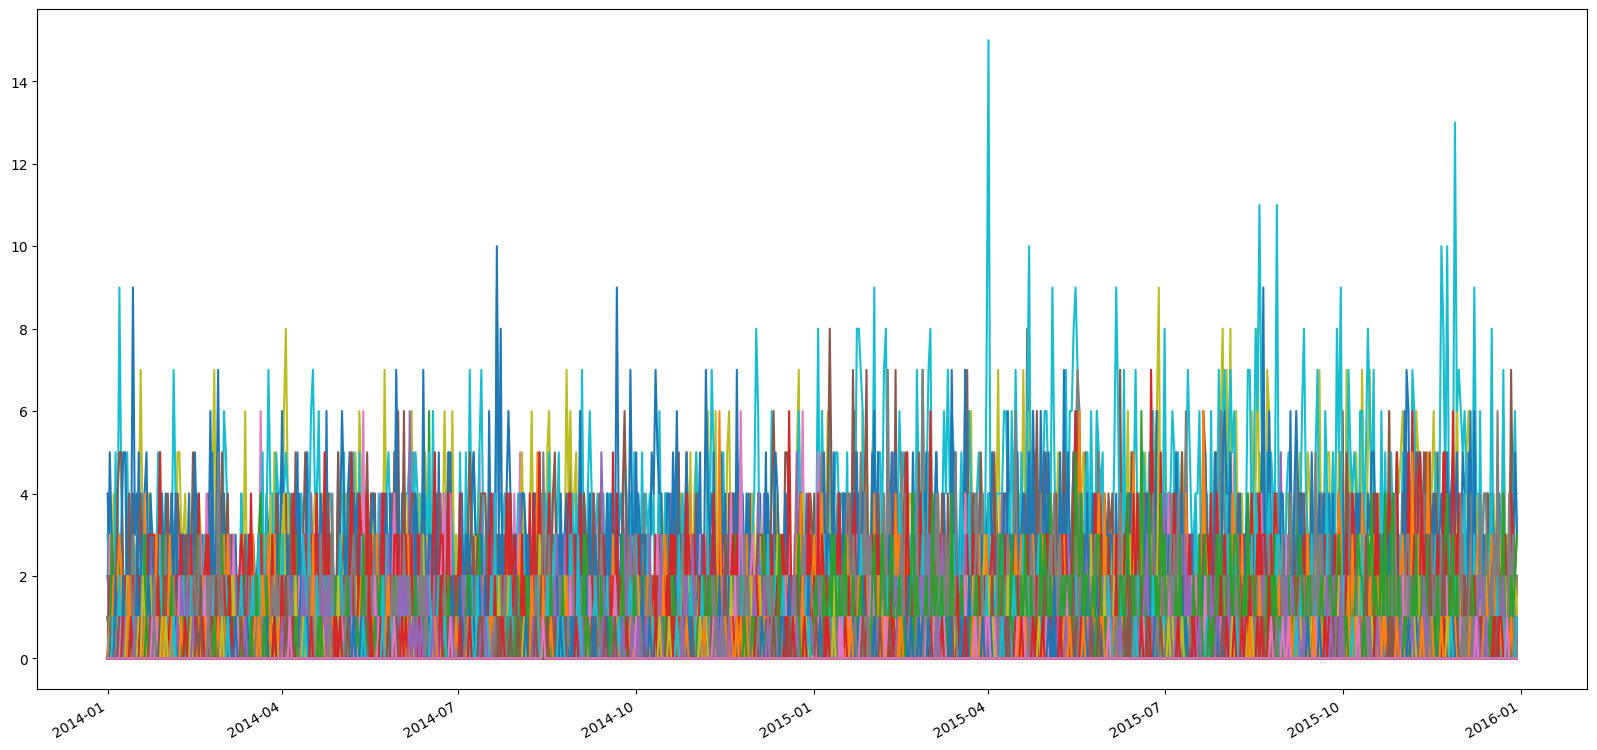

In [4]:
df_date_item_no.plot(legend=False, figsize=(20,10))  # plot all items

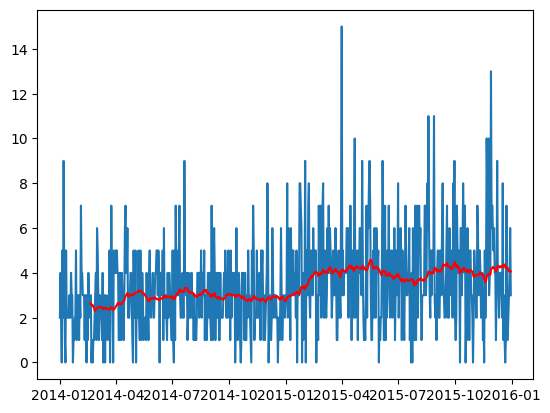

In [5]:
plt.plot(df_date_item_no[item_find])  # plot item
plt.plot(df_date_item_no[item_find].rolling(window=50).mean(), color='red')

In [6]:
df_resampled = df_date_item_no[[item_find,]].resample(order_cycle).sum()  # resample data to order cycle
print(df_resampled.head())
len(df_resampled)

date        whole milk
2014-01-01         6.0
2014-01-03         2.0
2014-01-05         7.0
2014-01-07        13.0
2014-01-09         1.0


365

In [7]:
#create a test train split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_resampled, test_size=0.2, shuffle=False)
len_train = len(train)
len_test = len(test)
print(f"Training Columns: {len_train}\nTesting Columns: {len_test}")

Training Columns: 292
Testing Columns: 73


In [8]:
import random
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")
# define the parameter space
PARAMETER_SPACE = {
    'p': range(1, 5),
    'd': range(1, 5),
    'q': range(1, 5)
}

def objective_function(params):
    p, d, q = params['p'], params['d'], params['q']
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()

    forecast_order = model_fit.forecast(steps=len_test)
    mse = mean_squared_error(test, forecast_order)
    return mse

In [9]:
def genetic_algorithm(population_size, generations):
    # initialize the population with random individuals
    population = []
    for i in range(population_size):
        individual = {}
        for param, values in PARAMETER_SPACE.items():
            individual[param] = random.choice(values)
        population.append(individual)
    print("Printing best of each Generation")
    # run the genetic algorithm for the specified number of generations
    for gen in range(generations):
        fitness = np.array([objective_function(individual) for individual in population])

        probabilities = fitness / fitness.sum()
        parents = np.random.choice(population, size=population_size // 2, replace=False, p=probabilities)

        # generate offspring by crossover and mutation
        offspring = []
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            child = {}
            for param in PARAMETER_SPACE.keys():
                if random.random() < 0.5:
                    child[param] = parent1[param]
                else:
                    child[param] = parent2[param]
                if random.random() < 0.3:
                    child[param] = random.choice(PARAMETER_SPACE[param])
            offspring.append(child)

        population = sorted(population + offspring, key=objective_function)[:population_size]
        print(f'Generation {gen + 1}: {population[0]} (fitness: {objective_function(population[0])})')

    best_individual = sorted(population, key=objective_function)[0]
    return best_individual

In [10]:
ga = genetic_algorithm(6, 6)
ideal_order = tuple(ga.values())
ideal_order

Printing best of each Generation
Generation 1: {'p': 2, 'd': 1, 'q': 1} (fitness: 13.192014767905768)
Generation 2: {'p': 2, 'd': 1, 'q': 1} (fitness: 13.192014767905768)
Generation 3: {'p': 2, 'd': 1, 'q': 1} (fitness: 13.192014767905768)
Generation 4: {'p': 2, 'd': 1, 'q': 1} (fitness: 13.192014767905768)
Generation 5: {'p': 2, 'd': 1, 'q': 1} (fitness: 13.192014767905768)
Generation 6: {'p': 2, 'd': 1, 'q': 1} (fitness: 13.192014767905768)


(2, 1, 1)

In [11]:
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
order_dict = {}
min_error = np.inf
try:
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                model_order_find = ARIMA(train, order=order).fit()
                forecast_order = model_order_find.forecast(steps=len_test)
                error = mean_squared_error(test, forecast_order)
                if error < min_error:
                    min_error = error
                order_dict[order] = error
                if (order[0] + order[1] + order[2]) % 4 == 0:
                    print(f"Order: {order} Error: {round(error,3)}")
except:
    pass
ideal_order_actual = (list(order_dict.keys())[list(order_dict.values()).index(min(order_dict.values(), ))])
print(f"Best Order: {ideal_order_actual} ({min_error})")

Order: (0, 0, 0) Error: 15.489
Order: (0, 0, 4) Error: 15.501
Order: (0, 1, 3) Error: 13.192
Order: (0, 2, 2) Error: 13.271
Order: (0, 3, 1) Error: 15057.655
Order: (0, 4, 0) Error: 259700336108.336
Order: (0, 4, 4) Error: 276.664
Order: (1, 0, 3) Error: 13.742
Order: (1, 1, 2) Error: 13.209
Order: (1, 2, 1) Error: 19.704
Order: (1, 3, 0) Error: 29328.07
Order: (1, 3, 4) Error: 14.067
Order: (1, 4, 3) Error: 1157.453
Order: (2, 0, 2) Error: 13.74
Order: (2, 1, 1) Error: 13.192
Order: (2, 2, 0) Error: 278.432
Order: (2, 2, 4) Error: 13.301
Order: (2, 3, 3) Error: 532.861
Order: (2, 4, 2) Error: 107.505
Order: (3, 0, 1) Error: 15.525
Order: (3, 1, 0) Error: 16.453
Order: (3, 1, 4) Error: 13.378
Order: (3, 2, 3) Error: 13.223
Order: (3, 3, 2) Error: 593.804
Order: (3, 4, 1) Error: 1872739.876
Best Order: (3, 3, 3) (12.980389197739814)


In [12]:
if not (ideal_order_actual == ideal_order):
    print("Genetic Algorithm did not give Optimal Result")
else:
    print("Genetic Algorithm gave Optimal Result")

Genetic Algorithm did not give Optimal Result


In [13]:
#sample parameters
model = ARIMA(train, order=ideal_order)  # create model (p,d,q)
model_ideal = ARIMA(train, order=ideal_order_actual)
results = model.fit()  # fit model
results_ideal = model_ideal.fit()
# Make predictions for the test set
forecast = results.forecast(steps=len_test)
forecast_ideal = results_ideal.forecast(steps=len_test)

print(forecast.head())
print(forecast_ideal.head())


2015-08-08    7.396410
2015-08-10    7.562698
2015-08-12    7.684160
2015-08-14    7.675980
2015-08-16    7.666920
Freq: 2D, Name: predicted_mean, dtype: float64
2015-08-08    9.207176
2015-08-10    9.818069
2015-08-12    9.313327
2015-08-14    9.321376
2015-08-16    9.361520
Freq: 2D, Name: predicted_mean, dtype: float64


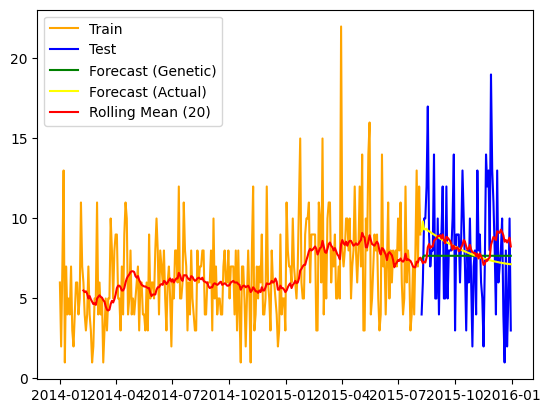

In [14]:
plt.plot(train.index, train, label='Train', color='orange')
plt.plot(test.index, test, label='Test', color = 'blue')
plt.plot(forecast.index, forecast, label='Forecast (Genetic)', color='green')
plt.plot(forecast_ideal.index, forecast_ideal, label='Forecast (Actual)', color='yellow')
plt.plot(df_resampled.rolling(window=20).mean(), color='red', label='Rolling Mean (20)')

plt.legend()
plt.show()  # plot Test, Train and Forecast results

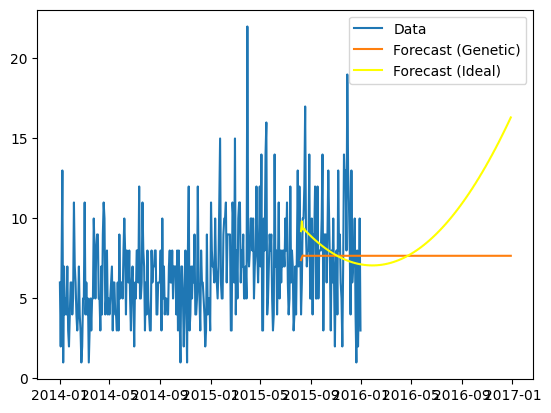

In [15]:
forecast_arima = results.forecast(steps=num_pred+len_test)
forecast_arima_ideal = results_ideal.forecast(steps=num_pred+len_test)
plt.plot(df_resampled.index, df_resampled, label='Data')
plt.plot(forecast_arima.index, forecast_arima, label='Forecast (Genetic)',)
plt.plot(forecast_arima_ideal.index, forecast_arima_ideal, label='Forecast (Ideal)', color='yellow')
plt.legend()
plt.show()  # plot Given Data and Forecast results for the next num_pred order cycles

In [16]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)

print("For Genetic Algorithm")
print(f"MAE: {round(mae,3)}")
print(f"RMSE: {round(rmse,3)}")
print(f"MAPE: {round(mape,3)}%")

mae_ideal = mean_absolute_error(test, forecast_ideal)
rmse_ideal = np.sqrt(mean_squared_error(test, forecast_ideal))
mape_ideal = mean_absolute_percentage_error(test, forecast_ideal)
print("\n\nFor Ideal Order")
print(f"MAE: {round(mae_ideal,3)}")
print(f"RMSE: {round(rmse_ideal,3)}")
print(f"MAPE: {round(mape_ideal,3)}%")


For Genetic Algorithm
MAE: 2.848
RMSE: 3.632
MAPE: 0.549%


For Ideal Order
MAE: 2.816
RMSE: 3.603
MAPE: 0.553%
